# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on April 13 (with 2-hour grace period) and worth 25 points

### Overview

This milestone builds on your work from Milestone 1. You will:

1. Evaluate baseline models using default settings.
2. Engineer new features and re-evaluate models.
3. Use feature selection techniques to find promising subsets.
4. Select the top 3 models and fine-tune them for optimal performance.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [4]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling.

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will not use the testing set during this milestone — it’s reserved for final evaluation later.
- You will have to redo the scaling step when you introduce new features (which have to be scaled as well).


In [5]:
# Add as many code cells as you need

df = pd.read_csv('zillow_dataset_cleaned.csv')
df = df.drop(columns=["rawcensustractandblock", "parcelid", "propertyzoningdesc", "taxdelinquencyyear"])
df = df.map(lambda x: 1 if x is True else (0 if x is False else x))
tax_flags = []
for i in df["taxdelinquencyflag"]:
    if i == 0:
        tax_flags.append(0)
    else:
        tax_flags.append(1)

df["taxdelinquencyflag"] = tax_flags


df

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,latitude,...,propertylandusetypeid_261.0,propertylandusetypeid_263.0,propertylandusetypeid_264.0,propertylandusetypeid_265.0,propertylandusetypeid_266.0,propertylandusetypeid_267.0,propertylandusetypeid_269.0,propertylandusetypeid_275.0,regionidcounty_2061.0,regionidcounty_3101.0
0,3.5,4.0,3.5,3100.0,3100.0,0.0,3.0,2.0,633.0,33634931.0,...,1,0,0,0,0,0,0,0,0,0
1,1.0,2.0,1.0,1465.0,1465.0,1.0,1.0,1.0,0.0,34449266.0,...,1,0,0,0,0,0,0,0,1,0
2,2.0,3.0,2.0,1243.0,1243.0,0.0,2.0,2.0,440.0,33886168.0,...,1,0,0,0,0,0,0,0,0,0
3,3.0,4.0,3.0,2376.0,2376.0,0.0,3.0,0.0,0.0,34245180.0,...,1,0,0,0,0,0,0,0,0,1
4,3.0,3.0,3.0,1312.0,1312.0,0.0,3.0,0.0,0.0,34185120.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70795,3.0,3.0,3.0,1741.0,1741.0,0.0,3.0,0.0,0.0,34202400.0,...,0,0,0,0,1,0,0,0,0,1
70796,2.0,2.0,2.0,1286.0,1286.0,0.0,2.0,0.0,0.0,34245368.0,...,1,0,0,0,0,0,0,0,0,1
70797,2.0,4.0,2.0,1612.0,1612.0,1.0,2.0,2.0,560.0,34300140.0,...,1,0,0,0,0,0,0,0,1,0
70798,1.0,3.0,1.0,1032.0,1032.0,0.0,1.0,0.0,0.0,34040895.0,...,1,0,0,0,0,0,0,0,0,1


In [6]:

df['calculatedbathnbr'] = df['calculatedbathnbr'].fillna(df['calculatedbathnbr'].mean())
df['calculatedfinishedsquarefeet'] = df['calculatedfinishedsquarefeet'].fillna(df['calculatedfinishedsquarefeet'].mean())
df['finishedsquarefeet12'] = df['finishedsquarefeet12'].fillna(df['finishedsquarefeet12'].mean())
df['fullbathcnt'] = df['fullbathcnt'].fillna(df['fullbathcnt'].mean())
df['lotsizesquarefeet'] = df['lotsizesquarefeet'].fillna(df['lotsizesquarefeet'].mean())
df['unitcnt'] = df['unitcnt'].fillna(df['unitcnt'].mean())
df['yearbuilt'] = df['yearbuilt'].fillna(df['yearbuilt'].mean()) 
df = df.dropna(how='any',axis=0) 


In [8]:
print(f"{df.isna().sum()}")

bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fireplacecnt                    0
fullbathcnt                     0
garagecarcnt                    0
garagetotalsqft                 0
latitude                        0
longitude                       0
lotsizesquarefeet               0
poolcnt                         0
propertycountylandusecode       0
regionidcity                    0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
taxdelinquencyflag              0
pooltypeid_merged               0
log_taxvaluedollarcnt           0
buildingqualitytypeid_2.0       0
buildingqualitytypeid_3.0       0
buildingqualitytypeid_4.0       0
buildingqualitytypeid_5.0       0
buildingqualitytypeid_6.0       0
buildingqualitytypeid_7.0       0
buildingqualitytypeid_8.0       0
buildingqualit

In [7]:

X = df.drop('log_taxvaluedollarcnt', axis=1)
y = df["log_taxvaluedollarcnt"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

### Part 1: Baseline Modeling [3 pts]

Apply the following regression models to the scaled training dataset using **default parameters**:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each model:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV RMSE Score** across all folds in a table. 


In [6]:
# Add as many code cells as you need
from sklearn.tree import DecisionTreeRegressor

model_scores = {}


linReg = LinearRegression()
ridgeReg = Ridge()
lassoReg = Lasso()
dTreeReg = DecisionTreeRegressor()
bagReg = BaggingRegressor()
rfReg = RandomForestRegressor()
gbReg = GradientBoostingRegressor()

models = [linReg, ridgeReg, lassoReg, dTreeReg, bagReg, rfReg, gbReg]
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

for model in models:
    model.fit(X_train_scaled, y_train)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=rkf, scoring='neg_mean_squared_error')
    print(f"{scores}")
    model_scores[str(model)] = scores


[-0.4789613  -0.48316995 -0.4862286  -0.49829389 -0.48340499 -0.493215
 -0.47849805 -0.49019376 -0.48842663 -0.48139867 -0.48848897 -0.48825688
 -0.48369082 -0.48804622 -0.48197807 -0.49346006 -0.48774038 -0.47537399
 -0.48631626 -0.48859767 -0.48922546 -0.49036147 -0.48478245 -0.48659174
 -0.4808594 ]
[-0.47895588 -0.4831712  -0.48623318 -0.49825849 -0.48340189 -0.49321546
 -0.47848268 -0.49013827 -0.48842731 -0.48138531 -0.48848747 -0.48824309
 -0.48369173 -0.48803723 -0.48195964 -0.49344239 -0.48774369 -0.4753742
 -0.48631527 -0.48860022 -0.48921876 -0.49035169 -0.48477855 -0.48659784
 -0.48085703]
[-0.77617488 -0.78379693 -0.78234693 -0.78201295 -0.80303225 -0.79563637
 -0.77338198 -0.78462438 -0.79538232 -0.77834019 -0.7943541  -0.78200629
 -0.77972163 -0.78209987 -0.78923187 -0.80014888 -0.76644512 -0.77349222
 -0.79155869 -0.79577531 -0.77171464 -0.80284908 -0.78883213 -0.7836795
 -0.78039813]
[-0.83574116 -0.82704138 -0.84312168 -0.85432214 -0.83965826 -0.82242713
 -0.86332532 

In [7]:
values = {}

for key, value in model_scores.items():
    values[key] = (np.mean(value), np.std(value))

In [8]:
pd.DataFrame(values)

,LinearRegression(),Ridge(),Lasso(),DecisionTreeRegressor(),BaggingRegressor(),RandomForestRegressor(),GradientBoostingRegressor()
0,-0.486222,-0.486215,-0.785481,-0.843961,-0.482779,-0.445635,-0.436044
1,0.005061,0.005057,0.009724,0.013843,0.006891,0.004747,0.005410


### Part 1: Discussion [2 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which models perform best overall?
  - Which are most stable (lowest std)?
  - Any signs of overfitting or underfitting?

> Your text here

### Part 2: Feature Engineering [3 pts]

Consider **at least three new features** based on your Milestone 1, Part 5. Examples include:
- Polynomial terms
- Log or interaction terms
- Groupings or transformations of categorical features

Add these features to `X_train` and then:
- Scale using `StandardScaler` 
- Re-run all models listed above (using default settings again).
- Report updated RMSE scores (mean and std) across repeated CV in a table. 

**Note:**  Recall that this will require creating a new version of the dataset, so effectively you may be running "polynomial regression" using `LinearRegression`. 

In [10]:
df_p2 = df.copy()

In [11]:
def log_transformation(df, columns):
    for col in columns:
        df[f"log {col}"] = np.log1p(df[col])
    return df
log_col = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12','garagetotalsqft', 'lotsizesquarefeet']
df_p2 = log_transformation(df_p2.copy(), log_col)

In [12]:
df_p2['room_size'] = df_p2['finishedsquarefeet12'] / df_p2['roomcnt']  # Finished sqft per room
df_p2['pool_to_lot_ratio'] = df_p2['poolcnt'] / df_p2['lotsizesquarefeet']  # Pools to lot size ratio




In [13]:
df_p2['room_size'] = df_p2['room_size'].replace(np.inf, 0)


In [14]:
X = df_p2.drop('log_taxvaluedollarcnt', axis=1)
y = df_p2["log_taxvaluedollarcnt"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
# Add as many code cells as you need
from sklearn.tree import DecisionTreeRegressor

model_scores_2 = {}


linReg = LinearRegression()
ridgeReg = Ridge()
lassoReg = Lasso()
dTreeReg = DecisionTreeRegressor()
bagReg = BaggingRegressor()
rfReg = RandomForestRegressor()
gbReg = GradientBoostingRegressor()

models = [linReg, ridgeReg, lassoReg, dTreeReg, bagReg, rfReg, gbReg]
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

for model in models:
    model.fit(X_train_scaled, y_train)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=rkf, scoring='neg_mean_squared_error')
    print(f"{scores}")
    model_scores_2[str(model)] = scores



[-0.4708789  -0.477591   -0.47999542 -0.49115457 -0.47733312 -0.48539497
 -0.47454693 -0.48398629 -0.47982732 -0.47382451 -0.48117458 -0.48265265
 -0.47797614 -0.48163508 -0.47355405 -0.48667648 -0.47957693 -0.46891638
 -0.478669   -0.48394427 -0.47903161 -0.48493444 -0.48051234 -0.4796515
 -0.47585633]
[-0.47089157 -0.47758971 -0.47999204 -0.49112293 -0.47732834 -0.48539287
 -0.47453814 -0.48394349 -0.47984659 -0.47381139 -0.48116778 -0.48265741
 -0.47799248 -0.48163036 -0.47353711 -0.48667397 -0.47958715 -0.46891663
 -0.47866834 -0.48395153 -0.47899229 -0.4849217  -0.48050953 -0.47964421
 -0.4758535 ]
[-0.77617488 -0.78379693 -0.78234693 -0.78201295 -0.80303225 -0.79563637
 -0.77338198 -0.78462438 -0.79538232 -0.77834019 -0.7943541  -0.78200629
 -0.77972163 -0.78209987 -0.78923187 -0.80014888 -0.76644512 -0.77349222
 -0.79155869 -0.79577531 -0.77171464 -0.80284908 -0.78883213 -0.7836795
 -0.78039813]
[-0.82634873 -0.84732925 -0.84127412 -0.84186226 -0.84047637 -0.82977026
 -0.8747137

In [15]:
values = {}

for key, value in model_scores_2.items():
    value = np.sqrt(np.array(-1 * value))
    values[key] = (np.mean(value), np.std(value))

In [16]:
pd.DataFrame(values)

,LinearRegression(),Ridge(),Lasso(),DecisionTreeRegressor(),BaggingRegressor(),RandomForestRegressor(),GradientBoostingRegressor()
0,0.692502,0.692498,0.886257,0.918687,0.694421,0.667040,0.660860
1,0.003576,0.003574,0.005484,0.006850,0.004159,0.004194,0.003775


### Part 2: Discussion [2 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

- Were there any unexpected results?



> Your text here

### Part 3: Feature Selection [3 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features.
- Report updated RMSE scores (mean and std) across repeated CV in a table.


<span style="color:skyblue">3.1 - Prepare Tools</span><br>

<span style="color:skyblue">3.2 - Feature Selection Per Model</span><br>
<span style="color:skyblue">3.2.1 - Linear Regression: Forward and Backward Feature Selection</span><br>
<span style="color:skyblue">3.2.2 - Ridge Regression: Forward and Backward Feature Selection</span><br>
<span style="color:skyblue">3.2.3 - Lasso Regression: sparse coefficients - best alpha via LassoCV</span><br>
<span style="color:skyblue">3.2.4 - Tree-Based Models (Decision Tree, Bagging, RF, GBT): Get feature importance </span><br>

<span style="color:skyblue">3.3 - Model Re-Evaluation on Selected Features</span><br>
<span style="color:skyblue">3.3.1 - Retrain Model only on selected features</span><br>
<span style="color:skyblue">3.3.2 - Use repeated CV to get mean</span><br>
<span style="color:skyblue">3.3.3 - Store results</span><br>

<span style="color:skyblue">3.4 - Present data with summary table</span><br>
<span style="color:skyblue">3.4.1 - Selected features</span><br>
<span style="color:skyblue">3.4.2 - Model, RMSE Mean (All Features), RMSE std (All Features), RMSE Mean (Selected Features), RMSE Std (Selected Features)</span><br>




In [28]:
# PART 3.1 PREPARE TOOLS

# Imports

from sklearn.model_selection   import train_test_split, cross_val_score
from sklearn.linear_model      import LinearRegression,Ridge,Lasso
from sklearn.model_selection   import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics           import mean_squared_error, r2_score
from sklearn.preprocessing     import StandardScaler 

# Forward Feature Selection

def forward_feature_selection(X, y, model, 
                              scoring='neg_mean_squared_error', 
                              cv=5, 
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"                                      
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score
    
    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far
    
    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]
            
            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]
            
        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (MSE): {current_score:.4f}")
        
        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()
        
        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )
    
# Backward Feature Selection

def backward_feature_selection(X, y, model, 
                               scoring='neg_mean_squared_error', 
                               cv=5, 
                               tol=None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"                                      
                               max_features=None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                               n_jobs=-1,
                               verbose=False
                              ):
    
    # Helper function to compute CV score using LinearRegression
    def cv_score(features):
        return -cross_val_score(model, X[features], y, 
                                scoring=scoring, cv=cv, 
                                n_jobs=n_jobs          ).mean()
    
    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)
    
    # Compute initial CV score with the full feature set
    initial_score = cv_score(features_remaining)
    
    # Initialize tracking variables
    best_score        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features = ['NONE']                     # List to record the order in which features are removed
    best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)
    
    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')
    
    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features
    
    prev_score = initial_score
    round_num = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')
            
        # Initialize variables to track the best removal in this round
        lowest_score = float('inf')
        feature_to_remove = None
        best_new_features = None
        
        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            if new_score < lowest_score:
                lowest_score = new_score
                feature_to_remove = feature
                best_new_features = new_feature_set
        
        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break
        
        # Update the best score and feature set if current removal improves performance
        if lowest_score < best_score:
            best_score = lowest_score
            best_feature_set = best_new_features.copy()
        
        # Update trackers for this round
        prev_score = lowest_score
        features_remaining = best_new_features
        selected_features.append(feature_to_remove)
        best_scores.append(lowest_score)
        
        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV score (MSE) {np.around(lowest_score, 4)}\n')
        round_num += 1

    return (
        selected_features,      # Order in which features were removed
        best_scores,            # CV scores after each removal step
        best_feature_set,       # Feature set that achieved the best CV score
        best_score              # Best (lowest) CV score
    )



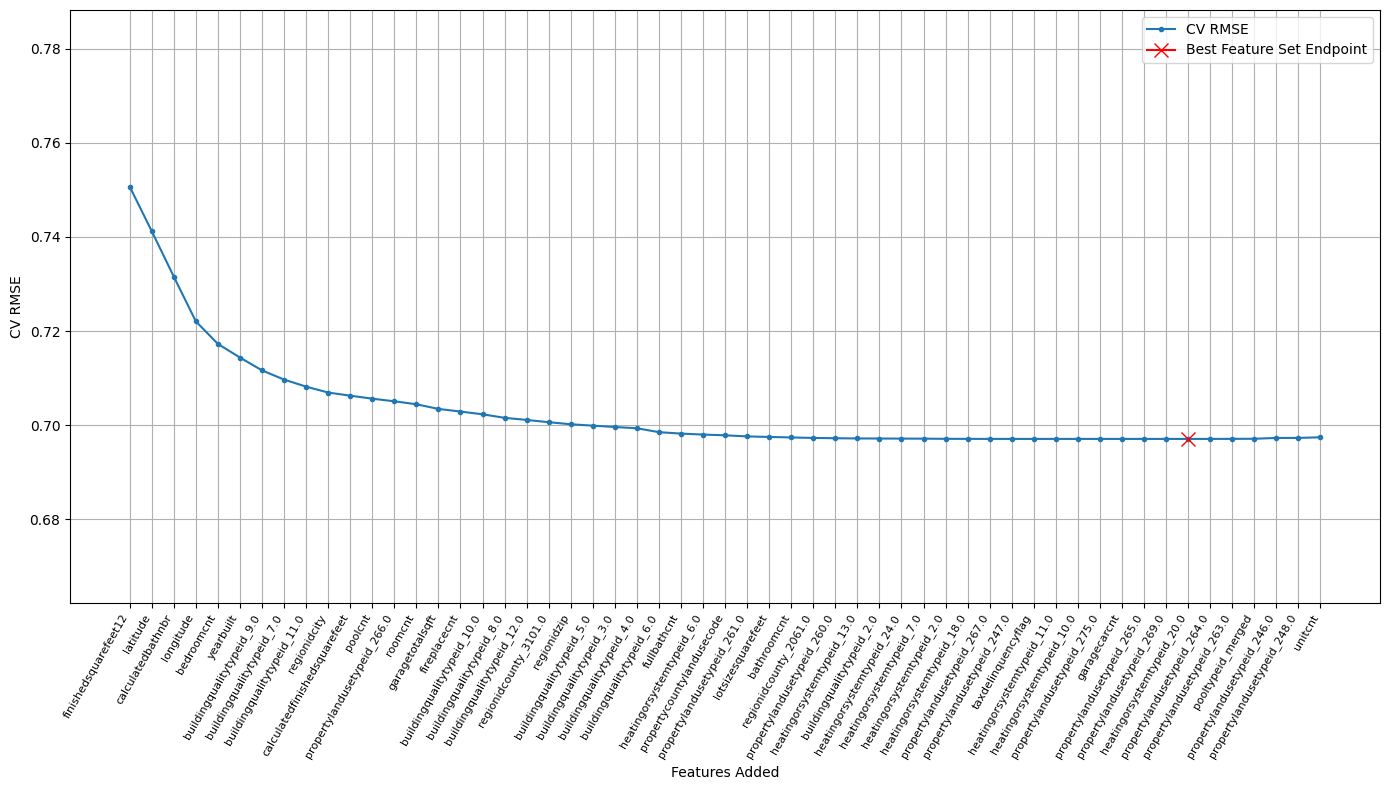

Best Features (Linear Regression - FWD): ['finishedsquarefeet12', 'latitude', 'calculatedbathnbr', 'longitude', 'bedroomcnt', 'yearbuilt', 'buildingqualitytypeid_9.0', 'buildingqualitytypeid_7.0', 'buildingqualitytypeid_11.0', 'regionidcity', 'calculatedfinishedsquarefeet', 'poolcnt', 'propertylandusetypeid_266.0', 'roomcnt', 'garagetotalsqft', 'fireplacecnt', 'buildingqualitytypeid_10.0', 'buildingqualitytypeid_8.0', 'buildingqualitytypeid_12.0', 'regionidcounty_3101.0', 'regionidzip', 'buildingqualitytypeid_5.0', 'buildingqualitytypeid_3.0', 'buildingqualitytypeid_4.0', 'buildingqualitytypeid_6.0', 'fullbathcnt', 'heatingorsystemtypeid_6.0', 'propertycountylandusecode', 'propertylandusetypeid_261.0', 'lotsizesquarefeet', 'bathroomcnt', 'regionidcounty_2061.0', 'propertylandusetypeid_260.0', 'heatingorsystemtypeid_13.0', 'buildingqualitytypeid_2.0', 'heatingorsystemtypeid_24.0', 'heatingorsystemtypeid_7.0', 'heatingorsystemtypeid_2.0', 'heatingorsystemtypeid_18.0', 'propertylandusetyp

In [29]:
# #3.2.1 - Linear Regression: Forward Feature Selection

# #need to transform np.array to pd df
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# model = LinearRegression()

# selected_features, best_scores, best_forward_features, best_score =    (
#         forward_feature_selection(X_train_scaled_df, y_train, model, verbose=False) )

# # Convert MSE to RMSE for all scores
# best_rmse_scores = np.sqrt(best_scores)
# best_rmse = np.sqrt(best_score)

# # Plot the results

# index = np.argmax(np.array(selected_features) == best_forward_features[-1])

# plt.figure(figsize=(14, 8))
# plt.plot(range(1, len(best_rmse_scores) + 1), best_rmse_scores, marker='.', label='CV RMSE')
# plt.plot([index + 1], best_rmse, marker='x', color='red', markersize=10, label='Best Feature Set Endpoint')
# plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=60, ha='right', fontsize=8)
# plt.ylim(min(best_rmse_scores) * 0.95, max(best_rmse_scores) * 1.05)  # Adjust y-axis range for visibility 
# plt.xlabel('Features Added')
# plt.ylabel('CV RMSE')
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

# # Print the best subset and RMSE score
# print(f"Best Features: {best_forward_features}")
# print(f"Best CV RMSE Score: {best_rmse:.4f}")


# 3.2.1 - Linear Regression: Forward Feature Selection

# Transform np.array to pd DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

lr_fwd_model = LinearRegression()

# Perform forward feature selection
lr_fwd_selected_features, lr_fwd_mse_scores, lr_fwd_best_features, lr_fwd_best_mse = (
    forward_feature_selection(X_train_scaled_df, y_train, lr_fwd_model, verbose=False)
)

# Convert MSE to RMSE
lr_fwd_rmse_scores = np.sqrt(lr_fwd_mse_scores)
lr_fwd_best_rmse = np.sqrt(lr_fwd_best_mse)

# Plot the results
lr_fwd_index = np.argmax(np.array(lr_fwd_selected_features) == lr_fwd_best_features[-1])

plt.figure(figsize=(14, 8))
plt.plot(range(1, len(lr_fwd_rmse_scores) + 1), lr_fwd_rmse_scores, marker='.', label='CV RMSE')
plt.plot([lr_fwd_index + 1], lr_fwd_best_rmse, marker='x', color='red', markersize=10, label='Best Feature Set Endpoint')
plt.xticks(range(1, len(lr_fwd_selected_features) + 1), lr_fwd_selected_features, rotation=60, ha='right', fontsize=8)
plt.ylim(min(lr_fwd_rmse_scores) * 0.95, max(lr_fwd_rmse_scores) * 1.05)
plt.xlabel('Features Added')
plt.ylabel('CV RMSE')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print the best subset and RMSE score
print(f"Best Features (Linear Regression - FWD): {lr_fwd_best_features}")
print(f"Best CV RMSE Score (Linear Regression - FWD): {lr_fwd_best_rmse:.4f}")


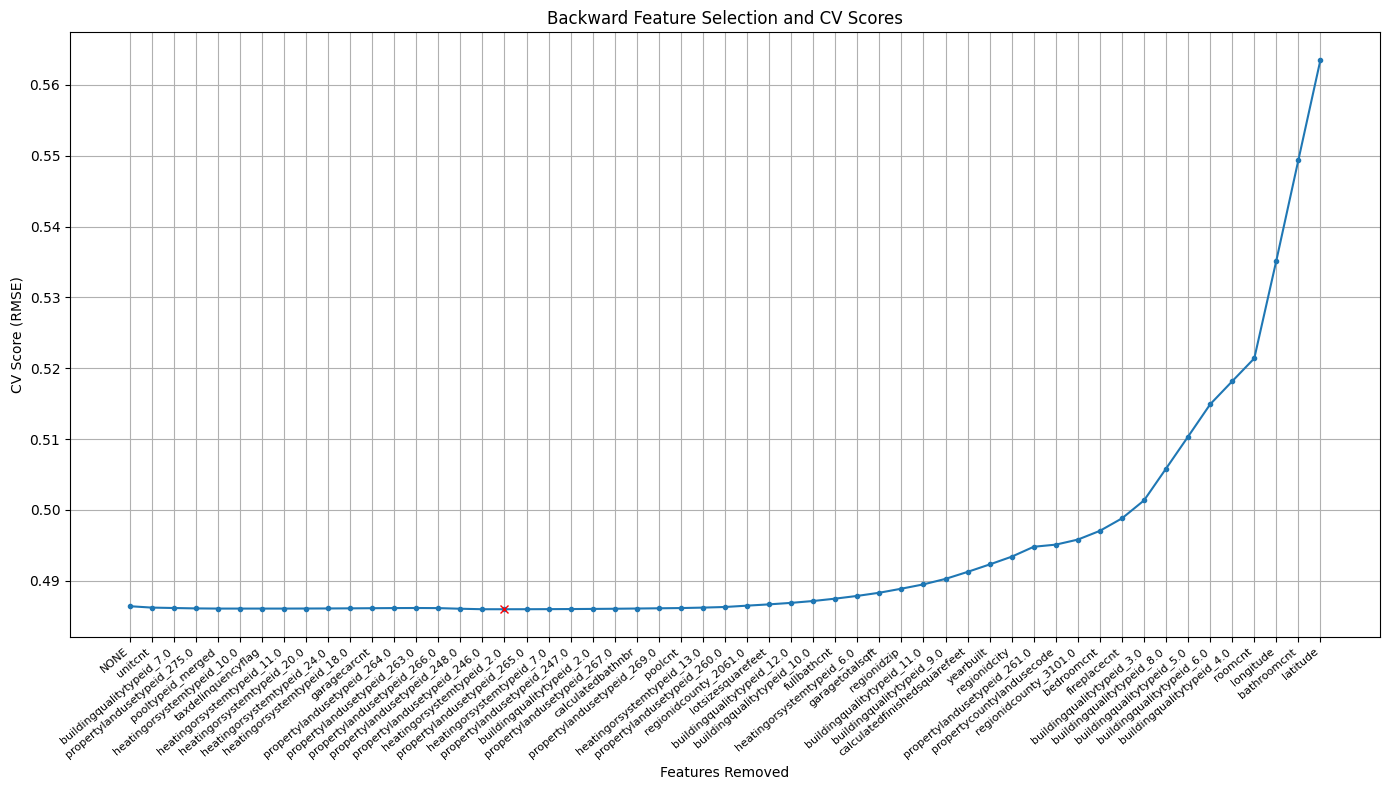

Best feature set (Linear Regression - BWD): ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fireplacecnt', 'fullbathcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'propertycountylandusecode', 'regionidcity', 'regionidzip', 'roomcnt', 'yearbuilt', 'buildingqualitytypeid_2.0', 'buildingqualitytypeid_3.0', 'buildingqualitytypeid_4.0', 'buildingqualitytypeid_5.0', 'buildingqualitytypeid_6.0', 'buildingqualitytypeid_8.0', 'buildingqualitytypeid_9.0', 'buildingqualitytypeid_10.0', 'buildingqualitytypeid_11.0', 'buildingqualitytypeid_12.0', 'heatingorsystemtypeid_6.0', 'heatingorsystemtypeid_7.0', 'heatingorsystemtypeid_13.0', 'propertylandusetypeid_247.0', 'propertylandusetypeid_260.0', 'propertylandusetypeid_261.0', 'propertylandusetypeid_265.0', 'propertylandusetypeid_267.0', 'propertylandusetypeid_269.0', 'regionidcounty_2061.0', 'regionidcounty_3101.0']
Best CV RMSE Score (Linear Regression - B

In [30]:
# #3.2.1 - Linear Regression:  Backward Feature Selection

# #need to transform np.array to pd df
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# model = LinearRegression()

# selected_features, best_scores, best_feature_set, best_score =    (
#         backward_feature_selection(X_train_scaled_df, y_train, model, verbose=False) )


# plt.figure(figsize=(14, 8))
# plt.title('Backward Feature Selection and CV Scores')
# plt.plot(range(1, len(best_scores) + 1), best_scores, marker='.')
# index = np.argmin(best_scores) 
# plt.plot([index + 1], best_scores[index], marker='x', color='red')  
# plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=40, ha='right', fontsize=8)
# plt.xlabel('Features Removed')
# plt.ylabel('CV Score (RMSE)')
# plt.grid()
# plt.tight_layout()
# plt.show()

# # Print minimum cv score

# print("Best feature set:", best_feature_set)
# print("CV score (MSE):",np.around(best_score,4))

# 3.2.1 - Linear Regression: Backward Feature Selection

# Transform np.array to pd DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

lr_bwd_model = LinearRegression()

# Perform backward feature selection
lr_bwd_selected_features, lr_bwd_mse_scores, lr_bwd_best_features, lr_bwd_best_mse = (
    backward_feature_selection(X_train_scaled_df, y_train, lr_bwd_model, verbose=False)
)

# Plot the results
plt.figure(figsize=(14, 8))
plt.title('Backward Feature Selection and CV Scores')
plt.plot(range(1, len(lr_bwd_mse_scores) + 1), lr_bwd_mse_scores, marker='.')
lr_bwd_index = np.argmin(lr_bwd_mse_scores)
plt.plot([lr_bwd_index + 1], lr_bwd_mse_scores[lr_bwd_index], marker='x', color='red')
plt.xticks(range(1, len(lr_bwd_selected_features) + 1), lr_bwd_selected_features, rotation=40, ha='right', fontsize=8)
plt.xlabel('Features Removed')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print best subset and corresponding RMSE
print("Best feature set (Linear Regression - BWD):", lr_bwd_best_features)
print("Best CV RMSE Score (Linear Regression - BWD):", np.sqrt(lr_bwd_best_mse).round(4))


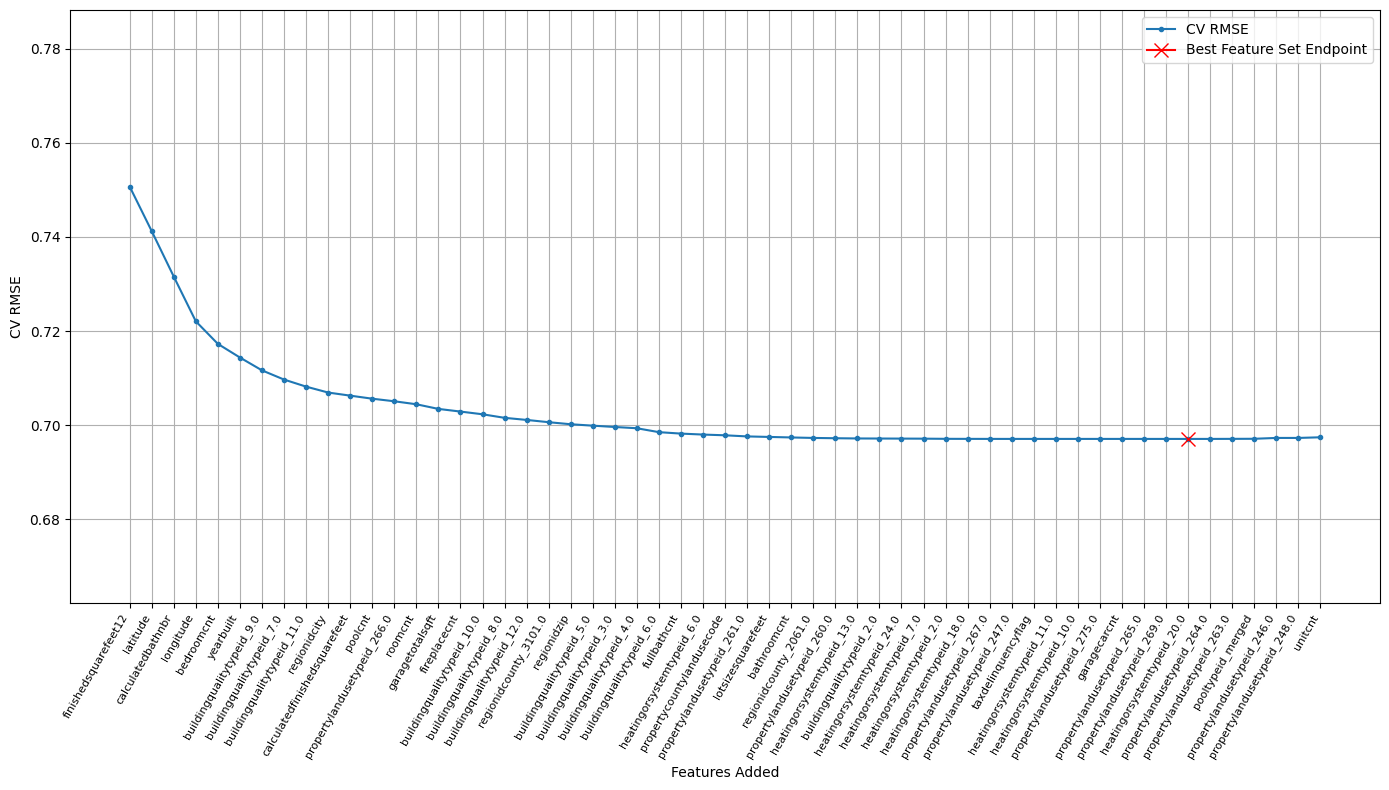

Best Features (Ridge - FWD): ['finishedsquarefeet12', 'latitude', 'calculatedbathnbr', 'longitude', 'bedroomcnt', 'yearbuilt', 'buildingqualitytypeid_9.0', 'buildingqualitytypeid_7.0', 'buildingqualitytypeid_11.0', 'regionidcity', 'calculatedfinishedsquarefeet', 'poolcnt', 'propertylandusetypeid_266.0', 'roomcnt', 'garagetotalsqft', 'fireplacecnt', 'buildingqualitytypeid_10.0', 'buildingqualitytypeid_8.0', 'buildingqualitytypeid_12.0', 'regionidcounty_3101.0', 'regionidzip', 'buildingqualitytypeid_5.0', 'buildingqualitytypeid_3.0', 'buildingqualitytypeid_4.0', 'buildingqualitytypeid_6.0', 'fullbathcnt', 'heatingorsystemtypeid_6.0', 'propertycountylandusecode', 'propertylandusetypeid_261.0', 'lotsizesquarefeet', 'bathroomcnt', 'regionidcounty_2061.0', 'propertylandusetypeid_260.0', 'heatingorsystemtypeid_13.0', 'buildingqualitytypeid_2.0', 'heatingorsystemtypeid_24.0', 'heatingorsystemtypeid_7.0', 'heatingorsystemtypeid_2.0', 'heatingorsystemtypeid_18.0', 'propertylandusetypeid_267.0', 

In [31]:
#3.2.2 - Ridge Regression: Forward Feature Selection

# #need to transform np.array to pd df
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# model = Ridge()

# selected_features, best_scores, best_forward_features, best_score =    (
#         forward_feature_selection(X_train_scaled_df, y_train, model, verbose=False) )

# # Convert MSE to RMSE for all scores
# best_rmse_scores = np.sqrt(best_scores)
# best_rmse = np.sqrt(best_score)

# # Plot the results

# index = np.argmax(np.array(selected_features) == best_forward_features[-1])

# plt.figure(figsize=(14, 8))
# plt.plot(range(1, len(best_rmse_scores) + 1), best_rmse_scores, marker='.', label='CV RMSE')
# plt.plot([index + 1], best_rmse, marker='x', color='red', markersize=10, label='Best Feature Set Endpoint')
# plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=60, ha='right', fontsize=8)
# plt.ylim(min(best_rmse_scores) * 0.95, max(best_rmse_scores) * 1.05)  # Adjust y-axis range for visibility 
# plt.xlabel('Features Added')
# plt.ylabel('CV RMSE')
# plt.legend()
# plt.grid()
# plt.tight_layout()
# plt.show()

# # Print the best subset and RMSE score
# print(f"Best Features: {best_forward_features}")
# print(f"Best CV RMSE Score: {best_rmse:.4f}")

# 3.2.2 - Ridge Regression: Forward Feature Selection

# Transform np.array to pd DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

ridge_fwd_model = Ridge()

# Perform forward feature selection
ridge_fwd_selected_features, ridge_fwd_mse_scores, ridge_fwd_best_features, ridge_fwd_best_mse = (
    forward_feature_selection(X_train_scaled_df, y_train, ridge_fwd_model, verbose=False)
)

# Convert MSE to RMSE
ridge_fwd_rmse_scores = np.sqrt(ridge_fwd_mse_scores)
ridge_fwd_best_rmse = np.sqrt(ridge_fwd_best_mse)

# Plot the results
ridge_fwd_index = np.argmax(np.array(ridge_fwd_selected_features) == ridge_fwd_best_features[-1])

plt.figure(figsize=(14, 8))
plt.plot(range(1, len(ridge_fwd_rmse_scores) + 1), ridge_fwd_rmse_scores, marker='.', label='CV RMSE')
plt.plot([ridge_fwd_index + 1], ridge_fwd_best_rmse, marker='x', color='red', markersize=10, label='Best Feature Set Endpoint')
plt.xticks(range(1, len(ridge_fwd_selected_features) + 1), ridge_fwd_selected_features, rotation=60, ha='right', fontsize=8)
plt.ylim(min(ridge_fwd_rmse_scores) * 0.95, max(ridge_fwd_rmse_scores) * 1.05)
plt.xlabel('Features Added')
plt.ylabel('CV RMSE')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Print the best subset and RMSE score
print(f"Best Features (Ridge - FWD): {ridge_fwd_best_features}")
print(f"Best CV RMSE Score (Ridge - FWD): {ridge_fwd_best_rmse:.4f}")



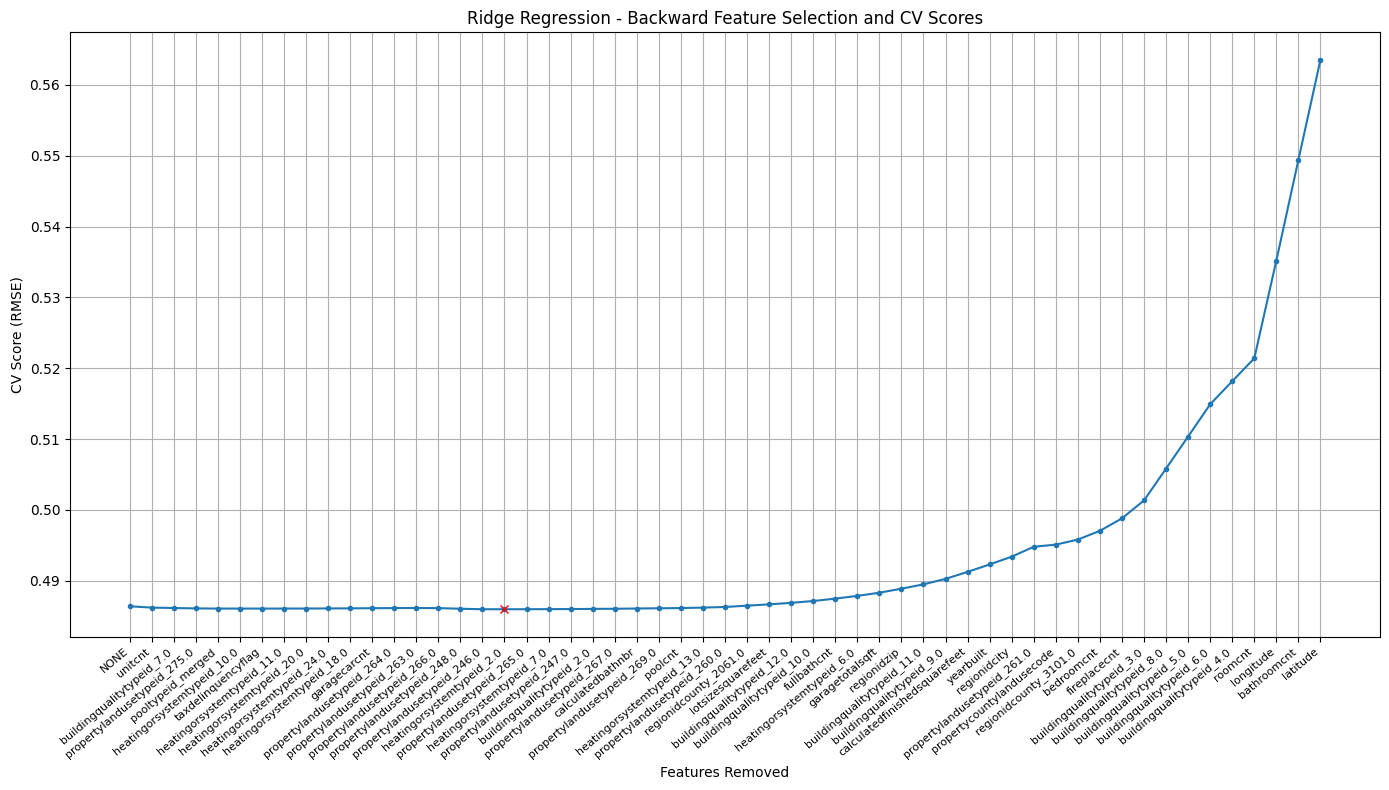

Best feature set (Ridge - BWD): ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fireplacecnt', 'fullbathcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'propertycountylandusecode', 'regionidcity', 'regionidzip', 'roomcnt', 'yearbuilt', 'buildingqualitytypeid_2.0', 'buildingqualitytypeid_3.0', 'buildingqualitytypeid_4.0', 'buildingqualitytypeid_5.0', 'buildingqualitytypeid_6.0', 'buildingqualitytypeid_8.0', 'buildingqualitytypeid_9.0', 'buildingqualitytypeid_10.0', 'buildingqualitytypeid_11.0', 'buildingqualitytypeid_12.0', 'heatingorsystemtypeid_6.0', 'heatingorsystemtypeid_7.0', 'heatingorsystemtypeid_13.0', 'propertylandusetypeid_247.0', 'propertylandusetypeid_260.0', 'propertylandusetypeid_261.0', 'propertylandusetypeid_265.0', 'propertylandusetypeid_267.0', 'propertylandusetypeid_269.0', 'regionidcounty_2061.0', 'regionidcounty_3101.0']
Best CV RMSE Score (Ridge - BWD): 0.6971


In [32]:
# #3.2.2 - Ridge Regression: Backwards Feature Selection

# #need to transform np.array to pd df
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# model = Ridge()

# selected_features, best_scores, best_forward_features, best_score =    (
#         backward_feature_selection(X_train_scaled_df, y_train, model, verbose=False) )


# plt.figure(figsize=(14, 8))
# plt.title('Backward Feature Selection and CV Scores')
# plt.plot(range(1, len(best_scores) + 1), best_scores, marker='.')
# index = np.argmin(best_scores) 
# plt.plot([index + 1], best_scores[index], marker='x', color='red')  
# plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=40, ha='right', fontsize=8)
# plt.xlabel('Features Removed')
# plt.ylabel('CV Score (RMSE)')
# plt.grid()
# plt.tight_layout()
# plt.show()

# # Print minimum cv score

# print("Best feature set:", best_feature_set)
# print("CV score (MSE):",np.around(best_score,4))

# 3.2.2 - Ridge Regression: Backward Feature Selection

# Transform np.array to pd DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

ridge_bwd_model = Ridge()

# Perform backward feature selection
ridge_bwd_selected_features, ridge_bwd_mse_scores, ridge_bwd_best_features, ridge_bwd_best_mse = (
    backward_feature_selection(X_train_scaled_df, y_train, ridge_bwd_model, verbose=False)
)

# Plot the results
plt.figure(figsize=(14, 8))
plt.title('Ridge Regression - Backward Feature Selection and CV Scores')
plt.plot(range(1, len(ridge_bwd_mse_scores) + 1), ridge_bwd_mse_scores, marker='.')
ridge_bwd_index = np.argmin(ridge_bwd_mse_scores)
plt.plot([ridge_bwd_index + 1], ridge_bwd_mse_scores[ridge_bwd_index], marker='x', color='red')
plt.xticks(range(1, len(ridge_bwd_selected_features) + 1), ridge_bwd_selected_features, rotation=40, ha='right', fontsize=8)
plt.xlabel('Features Removed')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print best subset and corresponding RMSE
print("Best feature set (Ridge - BWD):", ridge_bwd_best_features)
print("Best CV RMSE Score (Ridge - BWD):", np.sqrt(ridge_bwd_best_mse).round(4))



In [33]:
# #3.2.3 - Lasso Regression: sparse coefficients - best alpha via LassoCV

# from sklearn.linear_model import Lasso, LassoCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline

# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# #first, get best alpha
# lasso_cv = make_pipeline(StandardScaler(), LassoCV(cv=5)) #did we already scale the data?
# lasso_cv.fit(X_train_scaled_df, y_train)
# best_alpha = lasso_cv.named_steps['lassocv'].alpha_

# #do the lasso
# lasso = make_pipeline(StandardScaler(), Lasso(alpha=best_alpha))
# lasso.fit(X_train_scaled_df, y_train)

# #identify the features
# coef = lasso.named_steps['lasso'].coef_
# selected_features = np.where(coef != 0)[0]
# selected_feature_names = X_train_scaled_df.columns[coef != 0]
# print("Selected feature names:", selected_feature_names.tolist())

# #get the RMSE
# y_pred = lasso.predict(X_train_scaled_df)
# rmse = np.sqrt(mean_squared_error(y_train, y_pred))
# print("RMSE:", rmse)

# 3.2.3 - Lasso Regression: Sparse Coefficients - Best Alpha via LassoCV

from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Convert to DataFrame for easier tracking of feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Use pipeline to include scaling (even if already scaled, for safety with LassoCV)
lasso_cv_pipeline = make_pipeline(StandardScaler(), LassoCV(cv=5))
lasso_cv_pipeline.fit(X_train_scaled_df, y_train)

# Extract the best alpha
lasso_best_alpha = lasso_cv_pipeline.named_steps['lassocv'].alpha_

# Fit final Lasso model using best alpha
lasso_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=lasso_best_alpha))
lasso_pipeline.fit(X_train_scaled_df, y_train)

# Extract non-zero coefficients and corresponding features
lasso_coef = lasso_pipeline.named_steps['lasso'].coef_
lasso_selected_indices = np.where(lasso_coef != 0)[0]
lasso_selected_features = X_train_scaled_df.columns[lasso_coef != 0]

# Print selected features
print("Selected Features (Lasso):", lasso_selected_features.tolist())

# Compute RMSE
lasso_train_preds = lasso_pipeline.predict(X_train_scaled_df)
lasso_train_rmse = np.sqrt(mean_squared_error(y_train, lasso_train_preds))
print(f"Best Alpha (LassoCV): {lasso_best_alpha:.4f}")
print(f"CV RMSE (Lasso): {lasso_train_rmse:.4f}")

Selected Features (Lasso): ['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'propertycountylandusecode', 'regionidcity', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt', 'buildingqualitytypeid_2.0', 'buildingqualitytypeid_3.0', 'buildingqualitytypeid_4.0', 'buildingqualitytypeid_5.0', 'buildingqualitytypeid_6.0', 'buildingqualitytypeid_7.0', 'buildingqualitytypeid_8.0', 'buildingqualitytypeid_9.0', 'buildingqualitytypeid_10.0', 'buildingqualitytypeid_11.0', 'buildingqualitytypeid_12.0', 'heatingorsystemtypeid_2.0', 'heatingorsystemtypeid_6.0', 'heatingorsystemtypeid_7.0', 'heatingorsystemtypeid_13.0', 'heatingorsystemtypeid_18.0', 'heatingorsystemtypeid_20.0', 'heatingorsystemtypeid_24.0', 'propertylandusetypeid_247.0', 'propertylandusetypeid_248.0', 'propertylandusetypeid_260.0', 'propertylandusetypeid_261

Feature Importances (Decision Tree):
calculatedfinishedsquarefeet    2.850247e-01
latitude                        1.660665e-01
longitude                       1.121343e-01
finishedsquarefeet12            9.310537e-02
yearbuilt                       9.139569e-02
lotsizesquarefeet               8.637078e-02
regionidzip                     3.125473e-02
regionidcity                    1.883890e-02
bedroomcnt                      1.595474e-02
bathroomcnt                     1.548013e-02
garagetotalsqft                 1.340244e-02
propertycountylandusecode       8.189540e-03
calculatedbathnbr               6.090422e-03
roomcnt                         5.531890e-03
buildingqualitytypeid_8.0       4.700402e-03
heatingorsystemtypeid_7.0       4.188840e-03
buildingqualitytypeid_6.0       3.892794e-03
buildingqualitytypeid_4.0       3.790942e-03
pooltypeid_merged               3.310978e-03
buildingqualitytypeid_7.0       3.188200e-03
fireplacecnt                    3.164529e-03
buildingqualitytyp

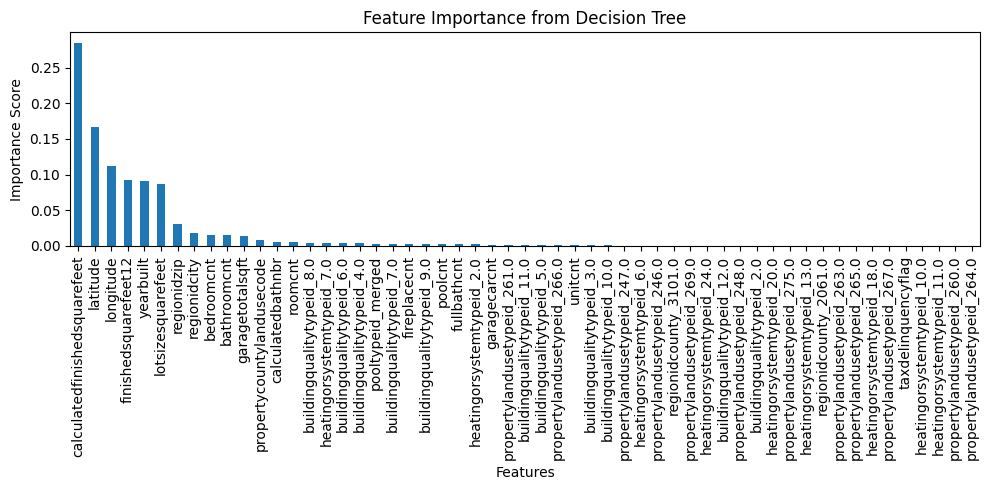

In [34]:
# #3.2.4 - Tree-Based Models: Decision Tree: Get feature importance

# from sklearn.tree import DecisionTreeRegressor  
# import pandas as pd

# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# tree = DecisionTreeRegressor() 
# tree.fit(X_train_scaled_df, y_train)

# #Getfeature names and importances
# importances = tree.feature_importances_ #gini or entropy?
# feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# print(feature_importance)

# #plot the importances
# feature_importance.plot(kind='bar', figsize=(10,5))
# plt.title("Feature Importance from Decision Tree")
# plt.ylabel("Importance Score")
# plt.show()


# 3.2.4 - Tree-Based Models: Decision Tree - Feature Importance

from sklearn.tree import DecisionTreeRegressor  
import pandas as pd

# Prepare scaled DataFrame with feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Train Decision Tree Regressor
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train_scaled_df, y_train)

# Get feature importances 
tree_feature_importance_scores = tree_model.feature_importances_
tree_feature_importance = pd.Series(tree_feature_importance_scores, index=X.columns).sort_values(ascending=False)

# Print sorted feature importances
print("Feature Importances (Decision Tree):")
print(tree_feature_importance)

# Plot the importances
plt.figure(figsize=(10, 5))
tree_feature_importance.plot(kind='bar')
plt.title("Feature Importance from Decision Tree")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()




Feature Importances (Bagging):
calculatedfinishedsquarefeet    2.035301e-01
finishedsquarefeet12            1.748580e-01
latitude                        1.624940e-01
longitude                       1.086544e-01
yearbuilt                       8.742258e-02
lotsizesquarefeet               8.330243e-02
regionidzip                     3.640956e-02
regionidcity                    2.180407e-02
bedroomcnt                      1.690083e-02
bathroomcnt                     1.471732e-02
garagetotalsqft                 1.350032e-02
propertycountylandusecode       8.731774e-03
calculatedbathnbr               8.289129e-03
roomcnt                         5.899591e-03
buildingqualitytypeid_8.0       5.434430e-03
buildingqualitytypeid_6.0       4.895898e-03
buildingqualitytypeid_4.0       3.874377e-03
heatingorsystemtypeid_7.0       3.765012e-03
buildingqualitytypeid_7.0       3.701962e-03
poolcnt                         3.430611e-03
buildingqualitytypeid_9.0       3.211078e-03
pooltypeid_merged       

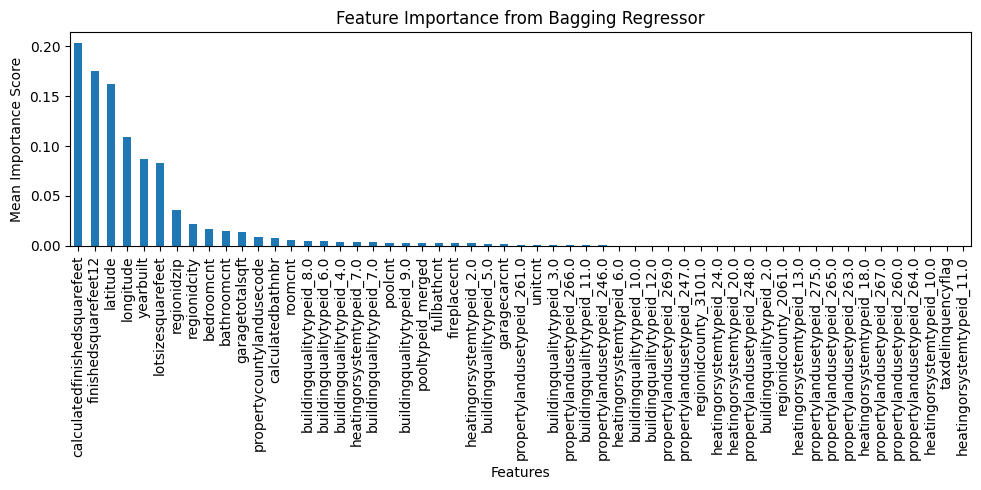

In [35]:
# #3.2.4 - Tree-Based Models: Bagging: Get feature importance

# from sklearn.ensemble import BaggingRegressor
# from sklearn.tree import DecisionTreeRegressor
# import pandas as pd
# import matplotlib.pyplot as plt

# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# #bagging ensemble with Decision Tree as base
# bagging = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)
# bagging.fit(X_train_scaled_df, y_train)

# #average feature importances across all trees
# importances = np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0)
# feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# print(feature_importance)

# #plot
# feature_importance.plot(kind='bar', figsize=(10,5))
# plt.title("Feature Importance from Bagging Regressor")
# plt.ylabel("Mean Importance Score")
# plt.tight_layout()
# plt.show()


# 3.2.4 - Tree-Based Models: Bagging - Feature Importance

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Prepare scaled DataFrame with feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Create Bagging Regressor with Decision Tree as base estimator
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)
bagging_model.fit(X_train_scaled_df, y_train)

# Average feature importances across all base estimators
bagging_feature_importances = np.mean(
    [tree.feature_importances_ for tree in bagging_model.estimators_],
    axis=0
)
bagging_feature_importance = pd.Series(bagging_feature_importances, index=X.columns).sort_values(ascending=False)

# Print sorted feature importances
print("Feature Importances (Bagging):")
print(bagging_feature_importance)

# Plot
plt.figure(figsize=(10, 5))
bagging_feature_importance.plot(kind='bar')
plt.title("Feature Importance from Bagging Regressor")
plt.ylabel("Mean Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()




Feature Importances (Random Forest):
calculatedfinishedsquarefeet    2.018480e-01
finishedsquarefeet12            1.766787e-01
latitude                        1.624786e-01
longitude                       1.087198e-01
yearbuilt                       8.738302e-02
lotsizesquarefeet               8.328713e-02
regionidzip                     3.626910e-02
regionidcity                    2.193900e-02
bedroomcnt                      1.697662e-02
bathroomcnt                     1.409676e-02
garagetotalsqft                 1.355452e-02
calculatedbathnbr               8.975735e-03
propertycountylandusecode       8.705871e-03
roomcnt                         5.847390e-03
buildingqualitytypeid_8.0       5.424653e-03
buildingqualitytypeid_6.0       4.888649e-03
buildingqualitytypeid_4.0       3.858059e-03
heatingorsystemtypeid_7.0       3.768661e-03
buildingqualitytypeid_7.0       3.681560e-03
poolcnt                         3.356614e-03
buildingqualitytypeid_9.0       3.226549e-03
pooltypeid_merged 

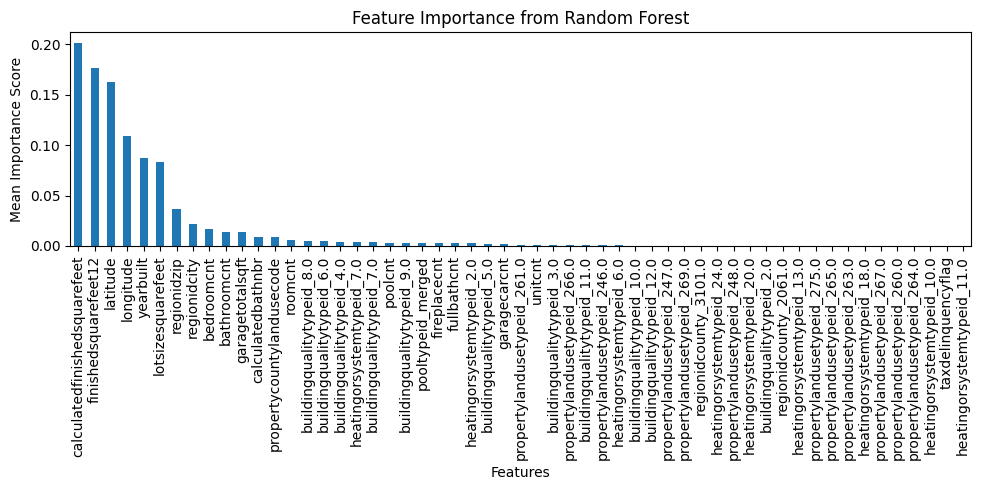

In [36]:
# #3.2.4 - Tree-Based Models: Random Forest: Get feature importance
# from sklearn.ensemble import RandomForestRegressor
# import pandas as pd
# import matplotlib.pyplot as plt

# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# #fit the model
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# rf.fit(X_train_scaled_df, y_train)

# #get importances
# importances = rf.feature_importances_
# feature_importance = pd.Series(importances, index=X_train_scaled_df.columns).sort_values(ascending=False)

# #display
# print(feature_importance)

# #plot
# feature_importance.plot(kind='bar', figsize=(10, 5))
# plt.title("Feature Importance from Random Forest")
# plt.ylabel("Mean Importance Score")
# plt.tight_layout()
# plt.show()

# 3.2.4 - Tree-Based Models: Random Forest - Feature Importance

from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt

# Prepare scaled DataFrame with feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled_df, y_train)

# Get feature importances
rf_feature_importances = rf_model.feature_importances_
rf_feature_importance = pd.Series(rf_feature_importances, index=X_train_scaled_df.columns).sort_values(ascending=False)

# Display feature importances
print("Feature Importances (Random Forest):")
print(rf_feature_importance)

# Plot
plt.figure(figsize=(10, 5))
rf_feature_importance.plot(kind='bar')
plt.title("Feature Importance from Random Forest")
plt.ylabel("Mean Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()


Feature Importances (Gradient Boosting):
bathroomcnt                     0.069539
bedroomcnt                      0.002493
calculatedbathnbr               0.062397
calculatedfinishedsquarefeet    0.246919
finishedsquarefeet12            0.278001
fireplacecnt                    0.000635
fullbathcnt                     0.000078
garagecarcnt                    0.000236
garagetotalsqft                 0.000000
latitude                        0.157117
longitude                       0.066824
lotsizesquarefeet               0.002875
poolcnt                         0.006561
propertycountylandusecode       0.004601
regionidcity                    0.010295
regionidzip                     0.004110
roomcnt                         0.001234
unitcnt                         0.000000
yearbuilt                       0.061417
taxdelinquencyflag              0.000000
pooltypeid_merged               0.000000
buildingqualitytypeid_2.0       0.000000
buildingqualitytypeid_3.0       0.000645
buildingqualityt

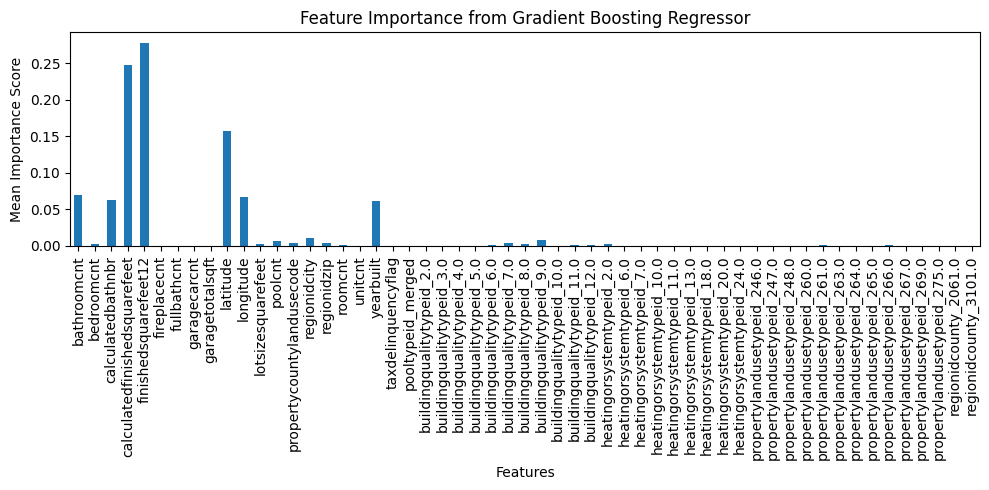

In [37]:
# #3.2.4 - Tree-Based Models: GBR: Get feature importance

# from sklearn.ensemble import GradientBoostingRegressor

# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# #gbr set up and fit
# gbr = GradientBoostingRegressor(random_state=42)
# gbr.fit(X_train_scaled_df, y_train)

# #average feature importances across all trees
# importances_gbr = pd.Series(gbr.feature_importances_, index=X_train_scaled_df.columns)
# selected_features_gbr = importances_gbr[importances_gbr > np.percentile(importances_gbr, 75)].index.tolist()
# print(importances_gbr)

# #plot
# importances_gbr.plot(kind='bar', figsize=(10,5))
# plt.title("Feature Importance from Bagging Regressor")
# plt.ylabel("Mean Importance Score")
# plt.tight_layout()
# plt.show()

# 3.2.4 - Tree-Based Models: Gradient Boosting Regressor (GBR) - Feature Importance

from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare scaled DataFrame with feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Set up and fit the GBR model
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train_scaled_df, y_train)

# Get feature importances
gbr_feature_importance = pd.Series(gbr_model.feature_importances_, index=X_train_scaled_df.columns)
gbr_top_features = gbr_feature_importance[gbr_feature_importance > np.percentile(gbr_feature_importance, 75)].index.tolist()

# Display importances
print("Feature Importances (Gradient Boosting):")
print(gbr_feature_importance)
print("\nTop 25% Selected Features (GBR):", gbr_top_features)

# Plot
plt.figure(figsize=(10, 5))
gbr_feature_importance.plot(kind='bar')
plt.title("Feature Importance from Gradient Boosting Regressor")
plt.ylabel("Mean Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()



In [54]:
#3.3 - Model Re-Evaluation on Selected Features



#Make helper functions - repeated CV, rmse_scorer, and model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer


#3.3.2 - Use repeated CV to get mean 
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
# rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)



#helper function to evaluate model
# def evaluate_model(model, X, y):
#     scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=cv)
#     return -np.mean(scores), np.std(scores)
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X_train_scaled_df, y_train, scoring=rmse_scorer, cv=cv)
    return -np.mean(scores), np.std(scores)

In [55]:
#3.3.1 - Retrain Model only on selected features


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

lr = LinearRegression()
ridge = Ridge()
lasso = Lasso(alpha=lasso_best_alpha)

rmse_lr_forward = evaluate_model(lr, X_train_scaled_df[lr_fwd_best_features], y_train)
rmse_lr_backward = evaluate_model(lr, X_train_scaled_df[lr_bwd_best_features], y_train)
rmse_ridge_forward = evaluate_model(ridge, X_train_scaled_df[ridge_fwd_best_features], y_train)
rmse_ridge_backward = evaluate_model(ridge, X_train_scaled_df[ridge_bwd_best_features], y_train)
rmse_lasso = evaluate_model(lasso, X_train_scaled_df[lasso_selected_features], y_train)

dt = DecisionTreeRegressor(random_state=42)
rmse_dt = evaluate_model(dt, X_train_scaled_df[tree_feature_importance.nlargest(int(len(tree_feature_importance)*0.25)).index], y_train)

bag = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, random_state=42)
rmse_bag = evaluate_model(bag, X_train_scaled_df[bagging_feature_importance.nlargest(int(len(bagging_feature_importance)*0.25)).index], y_train)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rmse_rf = evaluate_model(rf, X_train_scaled_df[rf_feature_importance.nlargest(int(len(rf_feature_importance)*0.25)).index], y_train)

gbr = GradientBoostingRegressor(random_state=42)
rmse_gbr = evaluate_model(gbr, X_train_scaled_df[gbr_feature_importance.nlargest(int(len(gbr_feature_importance)*0.25)).index], y_train)

In [56]:
#3.3.3 - Store results

results = pd.DataFrame({
    "Model": [
        "Linear Regression (Forward)",
        "Linear Regression (Backward)",
        "Ridge Regression (Forward)",
        "Ridge Regression (Backward)",
        "Lasso Regression",
        "Decision Tree",
        "Bagging",
        "Random Forest",
        "Gradient Boosting"
    ],
    "RMSE Mean": [
        rmse_lr_forward[0],
        rmse_lr_backward[0],
        rmse_ridge_forward[0],
        rmse_ridge_backward[0],
        rmse_lasso[0],
        rmse_dt[0],
        rmse_bag[0],
        rmse_rf[0],
        rmse_gbr[0]
    ],
    "RMSE Std": [
        rmse_lr_forward[1],
        rmse_lr_backward[1],
        rmse_ridge_forward[1],
        rmse_ridge_backward[1],
        rmse_lasso[1],
        rmse_dt[1],
        rmse_bag[1],
        rmse_rf[1],
        rmse_gbr[1]
    ]
})

print(results.round(4))

                          Model  RMSE Mean  RMSE Std
0   Linear Regression (Forward)     0.6972    0.0037
1  Linear Regression (Backward)     0.6972    0.0037
2    Ridge Regression (Forward)     0.6972    0.0037
3   Ridge Regression (Backward)     0.6972    0.0037
4              Lasso Regression     0.6972    0.0037
5                 Decision Tree     0.9205    0.0092
6                       Bagging     0.6675    0.0041
7                 Random Forest     0.6675    0.0040
8             Gradient Boosting     0.6603    0.0041


### Part 3: Discussion [2 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?

- How did feature selection differ between linear and tree-based models?

> Your text here

### Part 4: Fine-Tuning Your Top 3 Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far.

1. Choose the top 3 models based on performance and interpretability from earlier parts.
2. For each model:
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, or other techniques from previous homeworks. 
   - Experiment with different versions of your feature engineering and preprocessing — treat these as additional tunable components.
3. Report the mean and standard deviation of CV RMSE score for each model in a summary table.



In [38]:
# Add as many code cells as you need

### Part 4: Discussion [4 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?
- Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.
- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?

> Your text here